In [38]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor

In [39]:
data = pd.read_excel("../Dataset.xlsx", sheet_name=['Total Consumers'])
df = data['Total Consumers']
number_of_houses = len(df.columns)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,1.664,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,0.704291,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,1.659,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,0.689101,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,1.664,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,0.782819,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,1.697,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,0.648292,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


## Auxiliary functions

In [82]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    
    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mse)
    #wmape = np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    #mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
    mape = mae / actuals.mean()  
    r2 = r2_score(actuals, preds)

    # print performance metrics
    print('MSE: %.4f' % mse)
    print('RMSE: %.4f' % rmse)
    print('MAE: %.4f' % mae)
    print('MAPE: %.4f' % (mape * 100))
    print('R2: %.4f' % r2)
    return mse, rmse, mae, mape, r2

def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train.values.ravel())
    preds = model.predict(X_test)
    scores = cross_validate(estimator, X_train, y_train.values.ravel(), scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_squared_error'])
    return model, preds, scores

In [83]:
def total_averaged_metrics(metrics_list):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged RMSE: {}".format(np.round(sum(j for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged MAE: {}".format(np.round(sum(k for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged MAPE: {}".format(np.round(sum(l for i, j, k, l, m in metrics_list)*100/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(m for i, j, k, l, m in metrics_list)/len(metrics_list),3)))


def last_energy_points(df, number_timesteps):
    X = pd.DataFrame()
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df.shift(i)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y = pd.DataFrame(df[number_timesteps:])
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    return X, y

In [77]:
df_total = pd.DataFrame(df.sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,58.514142
1,57.575249
2,63.011688
3,62.735722
4,63.404029
...,...
35131,49.211311
35132,43.139892
35133,44.599341
35134,28.956084


### Normalize data

In [78]:
values = df_total.values
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(values)
df_total = pd.DataFrame(df_scaled)
df_total.columns = ['Energy']
df_total

,Energy
0,0.337053
1,0.331133
2,0.365410
3,0.363670
4,0.367883
...,...
35131,0.278398
35132,0.240118
35133,0.249320
35134,0.150689


## Preprocessing

In [79]:
X,y = last_energy_points(df_total, 2)
print(X.shape, y.shape)
X

(35134, 2) (35134, 1)


,Energy_15,Energy_30
0,0.331133,0.337053
1,0.365410,0.331133
2,0.363670,0.365410
3,0.367883,0.363670
4,0.369815,0.367883
...,...,...
35129,0.363083,0.216504
35130,0.278398,0.363083
35131,0.240118,0.278398
35132,0.249320,0.240118


### Split train and test

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

## Test model

In [68]:
metrics_list = []
for i in range(1,13):
    print("\nIteration ", i)
    X, y = last_energy_points(df_total, i)

    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)

    model, preds = build_model(GradientBoostingRegressor(), X_train, y_train, X_test)
    mse, rmse, mae, mape, r2 = performance_metrics(preds, y_test.values)
    metrics_list.append((mse,rmse,mae,mape,r2))


Iteration  1
MSE: 0.0048
RMSE: 0.0690
MAE: 0.0483
MAPE: 22.4566
R2: 0.7153

Iteration  2
MSE: 0.0048
RMSE: 0.0694
MAE: 0.0490
MAPE: 22.8220
R2: 0.7115

Iteration  3
MSE: 0.0046
RMSE: 0.0677
MAE: 0.0478
MAPE: 22.2809
R2: 0.7273

Iteration  4
MSE: 0.0047
RMSE: 0.0682
MAE: 0.0484
MAPE: 22.5086
R2: 0.7254

Iteration  5
MSE: 0.0046
RMSE: 0.0680
MAE: 0.0478
MAPE: 22.3610
R2: 0.7268

Iteration  6
MSE: 0.0046
RMSE: 0.0682
MAE: 0.0481
MAPE: 22.4447
R2: 0.7246

Iteration  7
MSE: 0.0045
RMSE: 0.0671
MAE: 0.0474
MAPE: 22.2958
R2: 0.7275

Iteration  8
MSE: 0.0047
RMSE: 0.0682
MAE: 0.0481
MAPE: 22.6159
R2: 0.7195

Iteration  9
MSE: 0.0048
RMSE: 0.0693
MAE: 0.0483
MAPE: 22.5951
R2: 0.7133

Iteration  10
MSE: 0.0047
RMSE: 0.0684
MAE: 0.0478
MAPE: 22.2119
R2: 0.7211

Iteration  11
MSE: 0.0045
RMSE: 0.0672
MAE: 0.0474
MAPE: 22.2709
R2: 0.7218

Iteration  12
MSE: 0.0047
RMSE: 0.0684
MAE: 0.0479
MAPE: 22.4218
R2: 0.7202


In [69]:
mse_list = []
rmse_list = []
mae_list = []
mape_list = []
r2_list = []

for i in range(0,12):
    mse_list.append(metrics_list[i][0])
    rmse_list.append(metrics_list[i][1])
    mae_list.append(metrics_list[i][2])
    mape_list.append(metrics_list[i][3] * 100)
    r2_list.append(metrics_list[i][4])

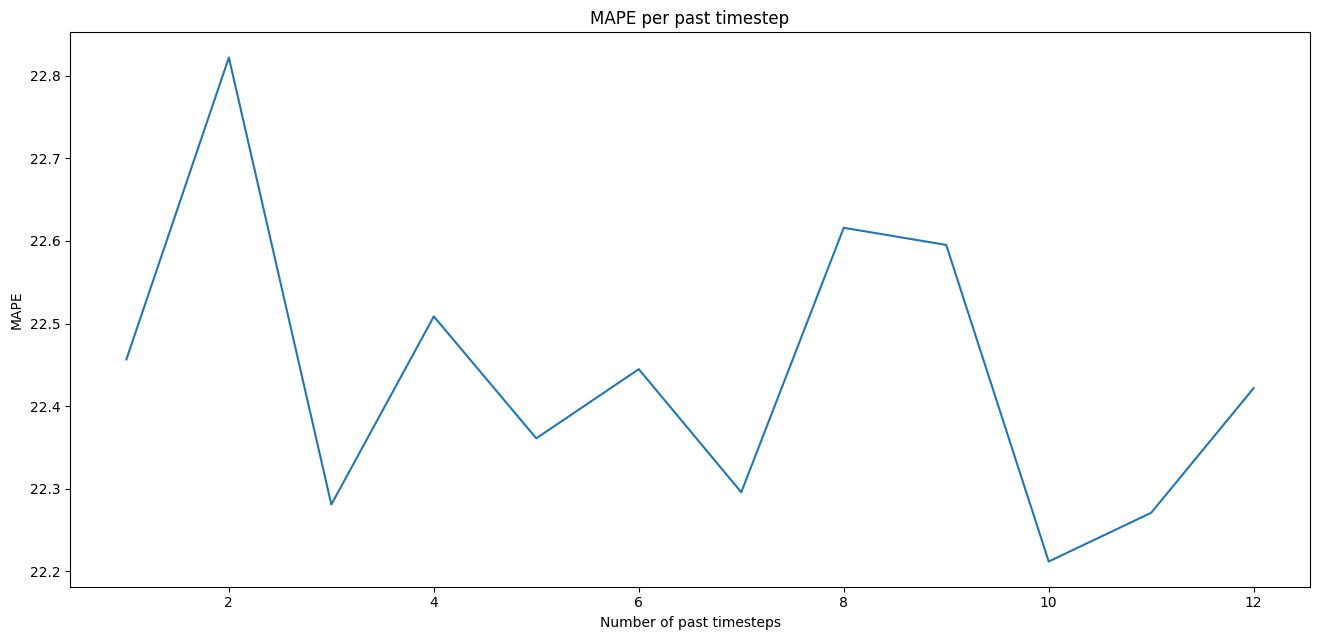

In [70]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), mape_list)
plt.title('MAPE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('MAPE')
plt.show()

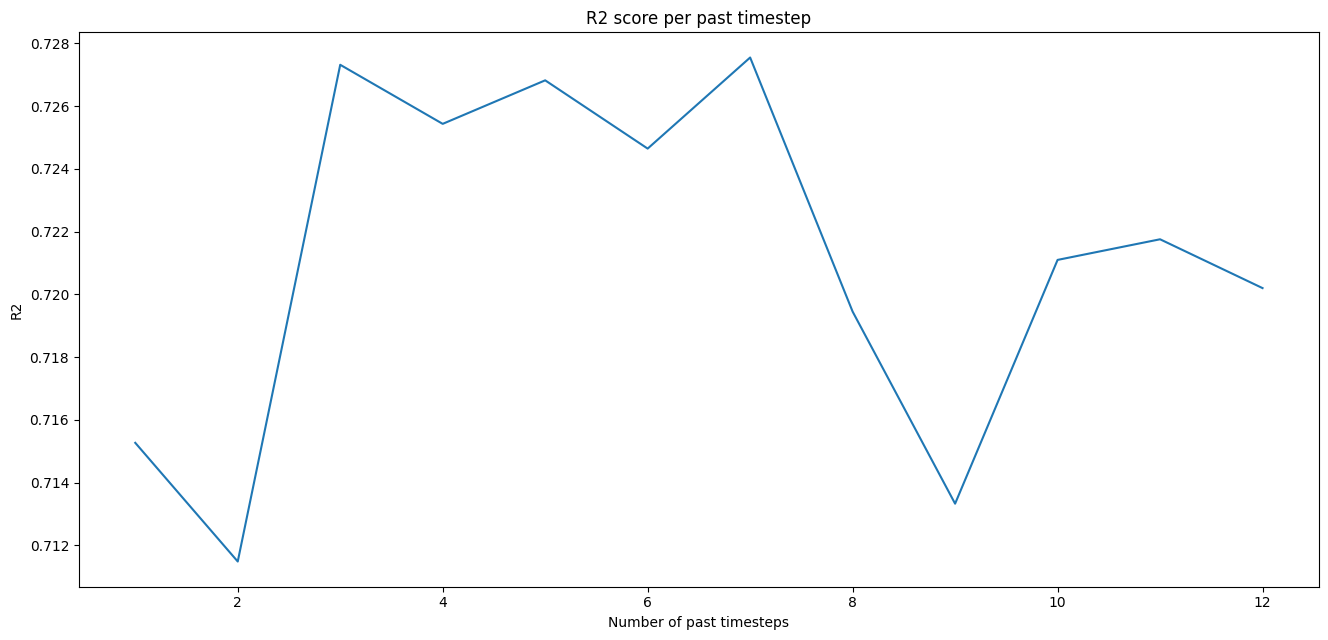

In [71]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), r2_list)
plt.title('R2 score per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('R2')
plt.show()

## Best model

In [84]:
X, y = last_energy_points(df_total, 7)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)

model, preds, scores = build_model(GradientBoostingRegressor(), X_train, y_train, X_test)
mse, rmse, mae, mape, r2 = performance_metrics(preds, y_test.values)

MSE: 0.0045
RMSE: 0.0671
MAE: 0.0474
MAPE: 22.2963
R2: 0.7276


In [87]:
scores

{'fit_time': array([6.64309311, 7.06536746, 6.54226995, 5.52341104, 5.11658835]),
 'score_time': array([0.0143218 , 0.00807405, 0.01049018, 0.00784397, 0.00768757]),
 'test_r2': array([0.72246905, 0.7140336 , 0.72102864, 0.71921658, 0.71852402]),
 'test_neg_root_mean_squared_error': array([-0.06770749, -0.06898756, -0.06859037, -0.06844768, -0.06681726]),
 'test_neg_mean_squared_error': array([-0.0045843 , -0.00475928, -0.00470464, -0.00468509, -0.00446455])}